# Auto Image Captioning

In [1]:
import os
from pandas import DataFrame
from tensorflow.keras.preprocessing import image, sequence
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import ssl
import plotly
from PIL import Image
from pickle import dump,load
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model,load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax
import ssl
from os import listdir

In [2]:
IMG_DIR="/home/sd2001/Desktop/Programming/Image Captioning/Flickr8k_Dataset/Flicker8k_Dataset"
TRAIN_IMG_NAME="/home/sd2001/Desktop/Programming/Image Captioning/Flickr8k_text/Flickr_8k.trainImages.txt"
TEST_IMG_NAME="/home/sd2001/Desktop/Programming/Image Captioning/Flickr8k_text/Flickr_8k.testImages.txt"
VALID_IMG_NAME="/home/sd2001/Desktop/Programming/Image Captioning/Flickr8k_text/Flickr_8k.devImages.txt"
IMG_CAPTION="/home/sd2001/Desktop/Programming/Image Captioning/Flickr8k_text/Flickr8k.token.txt"
LEMM_CAPTION="/home/sd2001/Desktop/Programming/Image Captioning/Flickr8k_text/Flickr8k.lemma.token.txt"


## Data Visualization and Understanding the Dataset

In [3]:
captions=open(IMG_CAPTION, 'r').read().split("\n")
x_train=open(TRAIN_IMG_NAME, 'r').read().split("\n")
x_val=open(VALID_IMG_NAME, 'r').read().split("\n")
x_test=open(TEST_IMG_NAME, 'r').read().split("\n")

In [4]:
c=captions[0].split('#')
c[1]

'0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [5]:
print("Image name :",c[0],"| Caption :",c[1][2:])

Image name : 1000268201_693b08cb0e.jpg | Caption : A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
img=[]
corpus=[]
ic={}
combined=[]
for c in range(len(captions)-1):
    a=captions[c].split('#')
    image=a[0]
    cp='Start '+a[1][2:]+' End'
    combined.append([image,cp])
    img.append(image)
    corpus.append(cp)
    if image in ic:
        ic[image].append(a[1][2:])
    else:
        ic[image] = [a[1][2:]]
combined

[['1000268201_693b08cb0e.jpg',
  'Start A child in a pink dress is climbing up a set of stairs in an entry way . End'],
 ['1000268201_693b08cb0e.jpg',
  'Start A girl going into a wooden building . End'],
 ['1000268201_693b08cb0e.jpg',
  'Start A little girl climbing into a wooden playhouse . End'],
 ['1000268201_693b08cb0e.jpg',
  'Start A little girl climbing the stairs to her playhouse . End'],
 ['1000268201_693b08cb0e.jpg',
  'Start A little girl in a pink dress going into a wooden cabin . End'],
 ['1001773457_577c3a7d70.jpg',
  'Start A black dog and a spotted dog are fighting End'],
 ['1001773457_577c3a7d70.jpg',
  'Start A black dog and a tri-colored dog playing with each other on the road . End'],
 ['1001773457_577c3a7d70.jpg',
  'Start A black dog and a white dog with brown spots are staring at each other in the street . End'],
 ['1001773457_577c3a7d70.jpg',
  'Start Two dogs of different breeds looking at each other on the road . End'],
 ['1001773457_577c3a7d70.jpg',
  'Start

In [7]:
combined_df=DataFrame(combined,columns=['Image','Caption'])
ds=combined_df.values

In [8]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sd2001/snap/jupyter/6/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
final_corpus=[]
dup_corpus=[]
for sent in corpus:
    words=word_tokenize(sent)
    
    for w in words:
        w=w.lower()
        if w=='.' or w=='!' or w==",":
            continue
        else:
            dup_corpus.append(w)
            if w in final_corpus:
                continue
            else:
                final_corpus.append(w)

final_corpus
        
    

['start',
 'a',
 'child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'an',
 'entry',
 'way',
 'end',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 'little',
 'playhouse',
 'the',
 'to',
 'her',
 'cabin',
 'black',
 'dog',
 'and',
 'spotted',
 'are',
 'fighting',
 'tri-colored',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'road',
 'white',
 'brown',
 'spots',
 'staring',
 'at',
 'street',
 'two',
 'dogs',
 'different',
 'breeds',
 'looking',
 'pavement',
 'moving',
 'toward',
 'covered',
 'paint',
 'sits',
 'front',
 'painted',
 'rainbow',
 'hands',
 'bowl',
 'sitting',
 'large',
 'small',
 'grass',
 'plays',
 'fingerpaints',
 'canvas',
 'it',
 'there',
 'pigtails',
 'painting',
 'young',
 'outside',
 'man',
 'lays',
 'bench',
 'while',
 'his',
 'by',
 'him',
 'which',
 'also',
 'tied',
 'sleeping',
 'next',
 'shirtless',
 'lies',
 'park',
 'laying',
 'holding',
 'leash',
 'ground',
 'orange',
 'hat',
 'starring',
 'something',
 'wears',
 

In [10]:
fdist1=nltk.FreqDist(dup_corpus)
#Get 50 Most Common Words
print (fdist1.most_common())

[('a', 62984), ('end', 40512), ('start', 40469), ('in', 18973), ('the', 18418), ('on', 10742), ('is', 9341), ('and', 8851), ('dog', 8135), ('with', 7764), ('man', 7266), ('of', 6710), ('two', 5639), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3505), ('woman', 3403), ('girl', 3328), ('to', 3173), ('wearing', 3062), ('at', 2916), ('people', 2887), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268), ('dogs', 2123), ('running', 2070), ('through', 2032), ('playing', 2008), ('while', 1968), ('down', 1825), ('shirt', 1806), ('standing', 1789), ('ball', 1779), ('little', 1768), ('grass', 1622), ('child', 1545), ('person', 1542), ('snow', 1492), ('jumping', 1472), ('over', 1414), ('front', 1385), ('three', 1383), ('sitting', 1368), ('holding', 1324), ('field', 1280), ('small', 1278), ('up', 1260), ('by', 1248), ('large', 1236), ('green', 1225), ('one', 1218), ('group', 1218), ('yellow', 1212), ('her', 1178), ('walking', 116

In [11]:
fd=fdist1.most_common()
words=[]
aa=[]
for i in range(len(fd)):
    aa=[]
    aa.append(fd[i][0])
    aa.append(fd[i][1])
    words.append(aa)
words

[['a', 62984],
 ['end', 40512],
 ['start', 40469],
 ['in', 18973],
 ['the', 18418],
 ['on', 10742],
 ['is', 9341],
 ['and', 8851],
 ['dog', 8135],
 ['with', 7764],
 ['man', 7266],
 ['of', 6710],
 ['two', 5639],
 ['white', 3940],
 ['black', 3832],
 ['boy', 3581],
 ['are', 3505],
 ['woman', 3403],
 ['girl', 3328],
 ['to', 3173],
 ['wearing', 3062],
 ['at', 2916],
 ['people', 2887],
 ['water', 2783],
 ['red', 2672],
 ['young', 2630],
 ['brown', 2563],
 ['an', 2432],
 ['his', 2357],
 ['blue', 2268],
 ['dogs', 2123],
 ['running', 2070],
 ['through', 2032],
 ['playing', 2008],
 ['while', 1968],
 ['down', 1825],
 ['shirt', 1806],
 ['standing', 1789],
 ['ball', 1779],
 ['little', 1768],
 ['grass', 1622],
 ['child', 1545],
 ['person', 1542],
 ['snow', 1492],
 ['jumping', 1472],
 ['over', 1414],
 ['front', 1385],
 ['three', 1383],
 ['sitting', 1368],
 ['holding', 1324],
 ['field', 1280],
 ['small', 1278],
 ['up', 1260],
 ['by', 1248],
 ['large', 1236],
 ['green', 1225],
 ['one', 1218],
 ['group'

In [12]:
df=DataFrame(words,columns=['Words','Count'])
#df=DataFrame(count, columns=['Count'])

In [13]:
df

Words  Count
0                a  62984
1              end  40512
2            start  40469
3               in  18973
4              the  18418
...            ...    ...
8906      spaniels      1
8907        weight      1
8908  majestically      1
8909      scrolled      1
8910      patterns      1

[8911 rows x 2 columns]

In [14]:
import plotly.express as px
fig = px.bar(df[:50], x='Words', y='Count',color="Count",title="Most freq occuring words")
fig.update_layout(
    font_family="Courier New",
    title_x=0.5,
    font_color="green",
    title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green"
)
fig.show()

## Preparing Data for our Model

In [15]:
def make_txt(file):
    f=open(file,'r')
    text=f.read()
    f.close()
    return text
txt=make_txt(IMG_CAPTION)
txt

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [16]:
def form_dict(img_list):
    img_dict={}
    for im in img_list:
        if im in ic:
            img_dict[im]=ic[im]
    return img_dict
form_dict(x_train)

{'2513260012_03d33305cf.jpg': ['A black dog is running after a white dog in the snow .',
  'Black dog chasing brown dog through snow',
  'Two dogs chase each other across the snowy ground .',
  'Two dogs play together in the snow .',
  'Two dogs running through a low lying body of water .'],
 '2903617548_d3e38d7f88.jpg': ['A little baby plays croquet .',
  'A little girl plays croquet next to a truck .',
  'The child is playing croquette by the truck .',
  'The kid is in front of a car with a put and a ball .',
  'The little boy is playing with a croquet hammer and ball beside the car .'],
 '3338291921_fe7ae0c8f8.jpg': ['A brown dog in the snow has something hot pink in its mouth .',
  'A brown dog in the snow holding a pink hat .',
  'A brown dog is holding a pink shirt in the snow .',
  'A dog is carrying something pink in its mouth while walking through the snow .',
  'A dog with something pink in its mouth is looking forward .'],
 '488416045_1c6d903fe0.jpg': ['A brown dog is runnin

In [17]:
def make_dict(txt):
    x={}
    for line in txt.split('\n'):
        tokens=line.split()
        if len(line)<3:
            continue
        image_id,image_desc=tokens[0],tokens[1:]
        image_id=image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in x:
            x[image_id]=list()
        x[image_id].append(image_desc)
    return x
    
descriptions=make_dict(txt)
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [18]:
import string
def clean_dict(des):
    table=str.maketrans('', '', string.punctuation)
    for key,desc_list in des.items():
        for i in range(len(desc_list)):
            desc=desc_list[i]
            desc=desc.split()
            desc=[word.lower() for word in desc]
            desc=[w.translate(table) for w in desc]
            desc=[word for word in desc if len(word)>1]
            desc=[word for word in desc if word.isalpha()]
            desc_list[i]= ' '.join(desc)
 
# clean descriptions
clean_dict(descriptions)
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with pi

In [19]:
def vocab_create(des):
    all=set()
    for k in des.keys():
        [all.update(d.split()) for d in des[k]]
    return all
vocabulary=vocab_create(descriptions)
len(vocabulary)

8763

In [20]:
def save_descriptions(descriptions):
    lines=[]
    for key,d in descriptions.items():
        for desc in d:
            lines.append(key + ' ' + desc)
    data='\n'.join(lines)
    file=open('descriptions.txt', 'w')
    file.write(data)
    file.close()
    
save_descriptions(descriptions)

In [21]:
def make_set(file):
    txt=make_txt(file)
    d=[]
    for line in txt.split('\n'):
        if len(line)<1:
            continue
        sent=line.split('.')[0]
        d.append(sent)
    return set(d)


In [22]:
def load_clean_dict(dataset):
    doc=make_txt('descriptions.txt')
    descriptions=dict()
    for line in doc.split('\n'):
        tokens=line.split()
        image_id,image_desc=tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc='startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [23]:
def load_photos(file,dataset):    
    filename='descriptions.txt'
    all_features=load(open(file, 'rb'))
    f={k: all_features[k] for k in dataset}
    return f

In [24]:
test=make_set(TEST_IMG_NAME)
print(len(test))
test_descriptions=load_clean_dict(test)
print(len(test))
test_features=load_photos('features.pkl',test)

1000
1000


In [25]:
train=make_set(TRAIN_IMG_NAME)
print('Dataset:%d' % len(train))
train_descriptions=load_clean_dict(train)
print('Descriptions:train=%d' % len(train_descriptions))
train_features=load_photos('features.pkl',train)
print('Photos:train=%d' % len(train_features))

Dataset:6000
Descriptions:train=6000
Photos:train=6000


In [26]:
def max_length(des):
    lines=to_lines(des)
    return max(len(d.split()) for d in lines)

In [27]:
def to_lines(des):
    all=[]
    for key in des.keys():
        [all.append(d) for d in des[key]]
    return all

def create_tokenizer(des):
    lines=to_lines(des)
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
tokenizer=create_tokenizer(train_descriptions)
vocab_size=len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [28]:
maxlen=max_length(train_descriptions)
maxlen

34

In [29]:
len(test_descriptions),len(train_descriptions)

(1000, 6000)

In [30]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1,X2,y=[],[],[]
    for desc in desc_list:
        seq=tokenizer.texts_to_sequences([desc])[0]
        for i in range(1,len(seq)):
            in_seq,out_seq=seq[:i], seq[i]
            in_seq=pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [31]:
def define_model(vocab_size, max_length):
    inputs1=Input(shape=(4096,))
    fe1=Dropout(0.5)(inputs1)
    fe2=Dense(256, activation='relu')(fe1)
    inputs2=Input(shape=(max_length,))
    se1=Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2=Dropout(0.5)(se1)
    se3=LSTM(256)(se2)
    decoder1=add([fe2, se3])
    decoder2=Dense(256, activation='relu')(decoder1)
    outputs=Dense(vocab_size, activation='softmax')(decoder2)
    model=Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [32]:
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key,desc_list in descriptions.items():
            photo=photos[key][0]
            in_img,in_seq, out_word=create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield ([in_img,in_seq],out_word)

In [33]:
train=make_set(TRAIN_IMG_NAME)
print('Dataset: %d' % len(train))
train_descriptions=load_clean_dict(train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features=load_photos('features.pkl',train)
print('Photos: train=%d' % len(train_features))
vocab_size=len(tokenizer.word_index) + 1
print(maxlen,vocab_size)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
34 7579


In [34]:
model=define_model(vocab_size, maxlen)
#Since I already trained this, I am loading a model instead of training once again
model=load_model('model_9.h5')
epochs=10
steps=len(train_descriptions)
#Do uncomment if the model is to be trained again
#for i in range(epochs):
    #generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)

    #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    #model.save('model_' + str(i) + '.h5')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [35]:
tokenizer=create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [36]:
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [37]:
def extract_features(file):
    model=VGG16()
    model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image=load_img(file, target_size=(224, 224))
    image=img_to_array(image)
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image=preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [38]:
def word2id(integer,tokenizer):
    for word,i in tokenizer.word_index.items():
        if i==integer:
            return word
    return None

In [44]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=maxlen)
        ypred=model.predict([photo,sequence], verbose=0)
        ypred=argmax(ypred)
        word=word2id(ypred, tokenizer)
        if word is None:
            break
        in_text+=' '+word
        if word == 'endseq':
            break
    return in_text

startseq man in helmet rides bike down dirt hill endseq


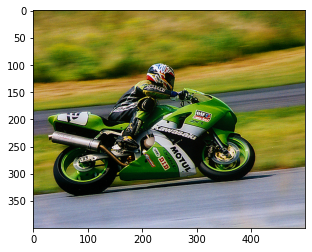

In [45]:
tokenizer=load(open('tokenizer.pkl', 'rb'))
max_length=34
model=load_model('model_9.h5')
pic='test13.jpg'
photo=extract_features(pic)
description=generate_desc(model, tokenizer, photo, max_length)
import matplotlib.pyplot as plt
%matplotlib inline
im = np.array(Image.open(pic))
plt.imshow(im)
print(description)